## Investment Stock Calculator

In [8]:
import pandas as pandas
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import style
import datetime as dt
import pandas as pd
import ipywidgets as w
import ipympl
style.use('ggplot')
pd.set_option('display.max_rows', 1000)


In [9]:
def dividend_per_stock(div_list, date):
    dividends = div_list[(div_list.index.month == date.month) & (div_list.index.year == date.year)]
    dividends = dividends.sum()
    return dividends

def investment_calc(ticker, start='2019-05-01', end='2021-05-01', monthly_investment=200.0):
    div_list = yf.Ticker(ticker).dividends
    hist = yf.download(ticker, start=start, end=end, interval='1mo')
    hist = hist.dropna()
    hist['invested_ammount'] = 0.0
    hist['monthly_investment'] = monthly_investment
    hist['total_investment'] = 0.00
    hist['total_stocks'] = 0.00
    hist['remainder'] = 0.00
    hist['dividends'] = 0.00

    line_total = hist.shape[0]

    for i in range(0, line_total):
        line = hist.iloc[i,:]
        date = hist.index[i]
        closing_price = line['Adj Close']
        if i > 0:
           previous_line = hist.iloc[i-1, :]
           previous_stock = previous_line['total_stocks']
           previous_remainder = previous_line['remainder']
        else:
            previous_stock = 0.00
            previous_remainder = 0.00
        dividends = dividend_per_stock(div_list, date)
        total_dividends = dividends*previous_stock
        total_investment = monthly_investment + previous_remainder + total_dividends
        new_stocks = int(total_investment/closing_price)
        total_stocks = previous_stock + new_stocks
        invested_ammount = total_stocks*closing_price
        remainder = total_investment - new_stocks*closing_price

        hist.at[date, 'invested_ammount'] = invested_ammount
        hist.at[date, 'total_investment'] = total_investment
        hist.at[date, 'total_stocks'] = total_stocks
        hist.at[date, 'remainder'] = remainder
        hist.at[date, 'dividends'] = total_dividends


    return hist

In [95]:
portfolio = [ 
    {"ticker": "QQQ",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     },
     {"ticker": "AAPL",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     },
     {"ticker": "GOOG",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     },
     {"ticker": "BAC",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     },
     {"ticker": "FB",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     },
     {"ticker": "MU",
    "start": "2019-05-01",
    "end": "2021-05-01",
    "monthly_investment": 200.0
     }
]

In [10]:
def calculate_wallet(portfolio):
    COLS = ['date', 'ticker', 'invested_ammount', 'monthly_investment', 'total_investment', 'total_stocks', 'dividends']
    result = pd.DataFrame(columns=COLS)
    if len(portfolio) > 0:
        for stock in portfolio:
            try:
                hist = investment_calc(
                    ticker=stock['ticker'], start=stock['start'], end=stock['end'], monthly_investment=stock['monthly_investment'])
                print('Stock calculated!')
                hist = hist.reset_index()
                hist = hist.rename(columns = {'Date': 'date'})
                hist['ticker'] = stock['ticker']
                result = result.append(hist[COLS], ignore_index=True)
            except:
                print('It was not possible to calculate: ', stock['ticker'])
                pass
        return result        

    else:
        print("Your wallet is empty")    

In [104]:
df = calculate_wallet(portfolio)

[*********************100%***********************]  1 of 1 completed
Stock calculated!
<ipython-input-94-1214f5faba80>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['invested_ammount'] = 0.0
<ipython-input-94-1214f5faba80>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['monthly_investment'] = monthly_investment
<ipython-input-94-1214f5faba80>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [19]:
def build_graph(result):
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(25,15))
    fig.suptitle('Wallet Performance', size=28, weight='bold')

    format_currency = ticker.StrMethodFormatter('U${x:,.0f}')
    ax1.yaxis.set_major_formatter(format_currency)
    ax2.yaxis.set_major_formatter(format_currency)
    ax3.yaxis.set_major_formatter(format_currency)
    ax4.yaxis.set_major_formatter(format_currency)

    ax1.set_title('Total invested in U$')
    ax2.set_title('Total invested by stock')
    ax3.set_title('Accumulated Dividends')
    ax4.set_title('Total dividends received')


    #pivot tables
    pivot_investments = result.pivot(index='date', columns='ticker', values='monthly_investment').fillna(0)
    pivot_dividends = result.pivot(index='date', columns='ticker', values='dividends').fillna(0)
    pivot_invested_ammount = result.pivot(index='date', columns='ticker', values='invested_ammount').fillna(0)
    pivot_accumulated_dividend = pivot_dividends.cumsum()

    pivot_investments.plot.area(ax=ax2, stacked=True)
    pivot_invested_ammount.plot.area(ax=ax1, stacked=True)
    pivot_accumulated_dividend.plot.area(ax=ax3, stacked=True)
    pivot_dividends.plot.line(ax=ax4, stacked=False)
    
    

    return fig


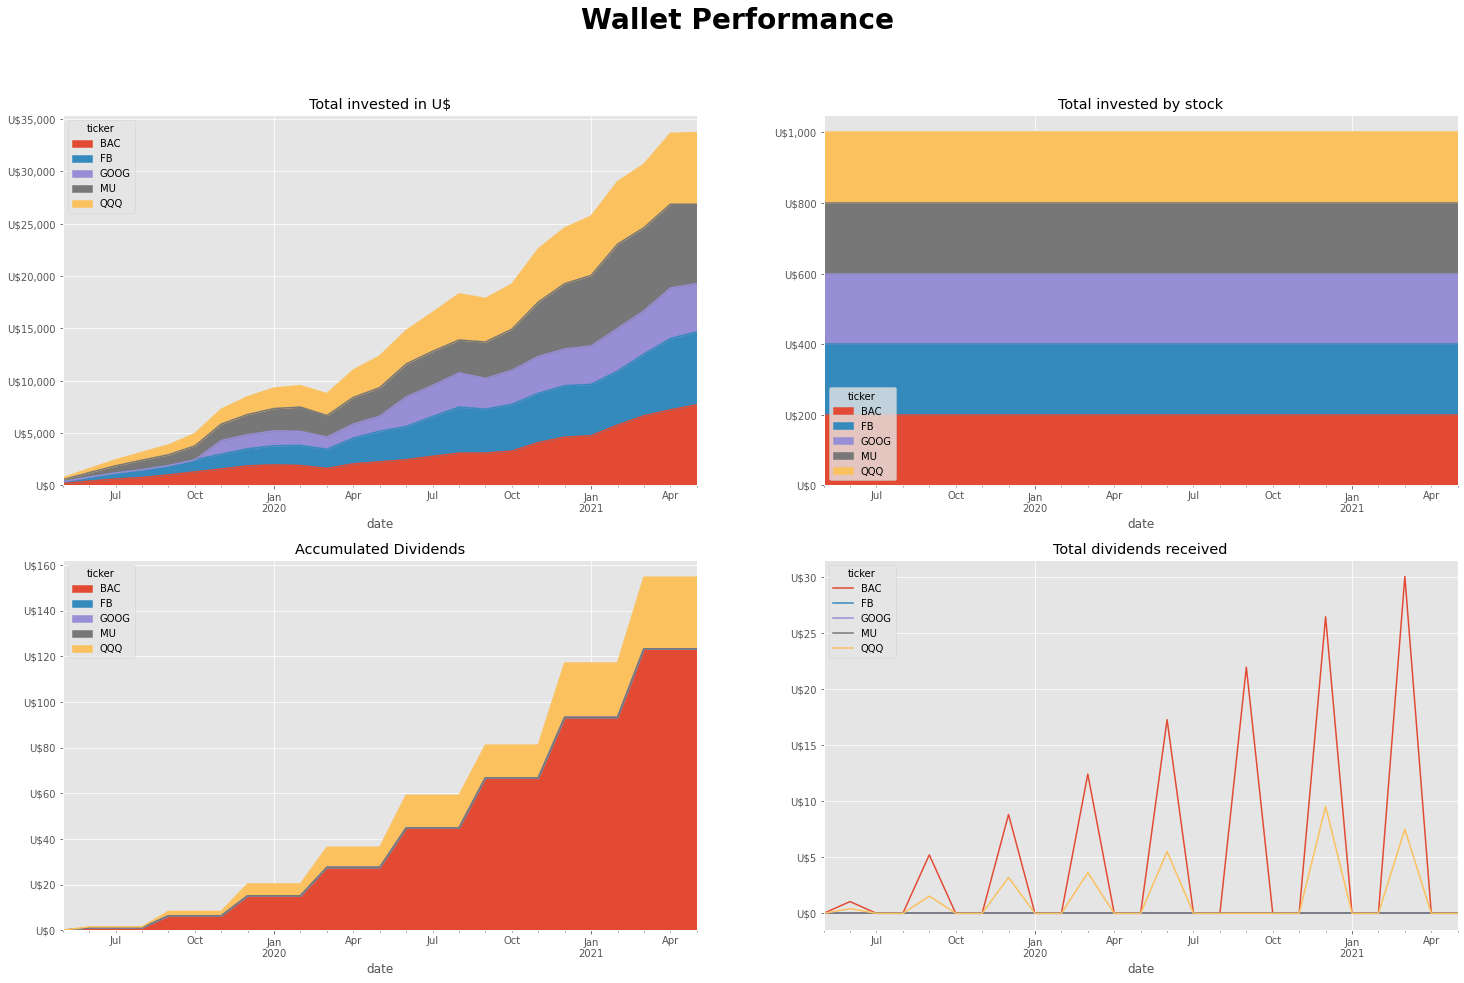

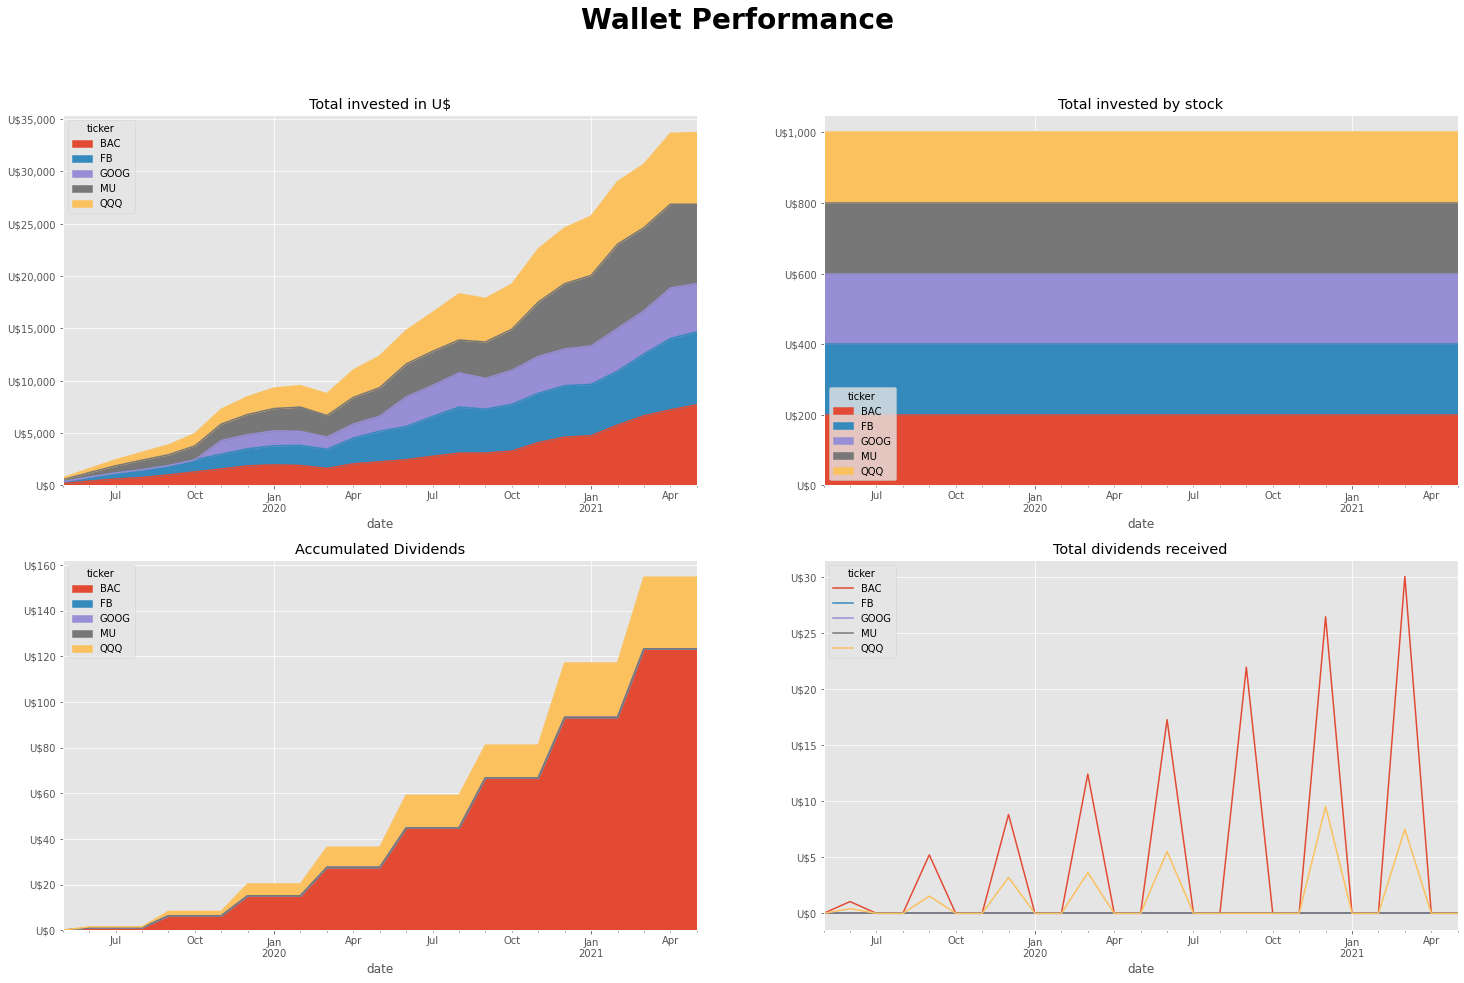

In [106]:
build_graph(df)

## Graphic interface

In [20]:
def create_wallet(tickers_list, investment, start, end):
    wallet = []
    for ticker in tickers_list:
        stock = {
            'ticker': ticker.strip(),
            'start': start,
            'end': end,
            'monthly_investment': investment
        }
        wallet.append(stock)
    return wallet   

def process(b):
    with output:
        tickers_list = tickers.value.split(',')
        monthly_investment = int(investment_slider.value)
        start = start_date.value 
        end = end_date.value 
        wallet = create_wallet(tickers_list, monthly_investment, start, end)
        df = calculate_wallet(wallet)
        figure = build_graph(df)
        output.clear_output()
        display(figure)

output = w.Output()

header = w.HTML("<h1>Investments Calculator</h1>", layout=w.Layout(height='auto'))

tickers = w.Text(placeholder='AAPL, QQQ,...')
ticker_label = w.Label('Enter tickers separeted by comma.')

start_date = w.DatePicker()
start_date_label = w.Label('Choose a starting date')

end_date = w.DatePicker()
end_date_label = w.Label('Choose an ending date')

investment_text = w.FloatText()
investment_slider = w.FloatSlider(min=0, max=10000, step=100)
investment_label = w.Label('Select monthly investment')

w.jslink((investment_text, 'value'),(investment_slider, 'value'))

submit_button = w.Button(description='Calculate', Layout={'padding':'0px 20px', 'margin':'20px 5px'}, button_style='success', icon='play')

submit_button.on_click(process)

menu = w.VBox([ticker_label, tickers, start_date_label, start_date, end_date_label, end_date, investment_label, investment_text, investment_slider, submit_button], Layout=w.Layout(padding='20px'))

w.AppLayout(header=header, left_sidebar=menu, center=output, right_sidebar=None, footer=None, height='1000px', grid_gap='20px')

AppLayout(children=(HTML(value='<h1>Investments Calculator</h1>', layout=Layout(grid_area='header', height='au…